In [28]:
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import bt
from bt.core import Algo
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import risk_matrix
import numpy as np
from datetime import datetime
from pandas_datareader import data as wb
import datetime as dt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [29]:
#main_tickers = ['FNTN.DE', 'NLM.F', 'MMK.VI', 'WIE.VI', 'FHZN.SW', 'LXS.DE', 'TGYM.MI', 'NDX1.DE', '39K.F', 'MOR.DE'] # ,'TMV.DE' #Data is imported from yahoo finance in the currency stated there
#main_tickers = ['VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV'] #US factor portfolio
#main_tickers = ['IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV'] #International factor portfolio 
#main_tickers = ['IVLU', 'IMTM', 'IQLT', 'ISZE', 'ACWV', 'VLUE', 'QUAL', 'MTUM', 'SIZE', 'USMV'] # US + International Factor portfolio 
main_tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD']
#benchmark = ['EUMD.L'] # FS Invest portfolio 
#benchmark = ['SPY'] #US Factor portfolio 
benchmark = ['SPY'] #World Factor portfolio 
main_benchmark_tickers = ['SPY', 'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD' ] #Factor portfolio 
#main_benchmark_tickers = ['EUMD.L', 'FNTN.DE', 'NLM.F', 'MMK.VI', 'WIE.VI', 'FHZN.SW', 'KP5.F', 'LXS.DE', 'TGYM.MI', 'NDX1.DE', '39K.F', 'MOR.DE','TMV.DE'] #FS invest portfolio
today = dt.date.today()
start_date_input = today - dt.timedelta(days=365*5) #importing data five years back 



In [30]:
def import_stock_data(tickers, start, end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

plot_data = import_stock_data(tickers = main_benchmark_tickers, start = start_date_input).dropna()

data = import_stock_data(tickers = main_tickers, start = start_date_input).dropna()

data_benchmark = import_stock_data(tickers = benchmark, start = start_date_input).dropna() #Truncate data depending on the start of backtesting 


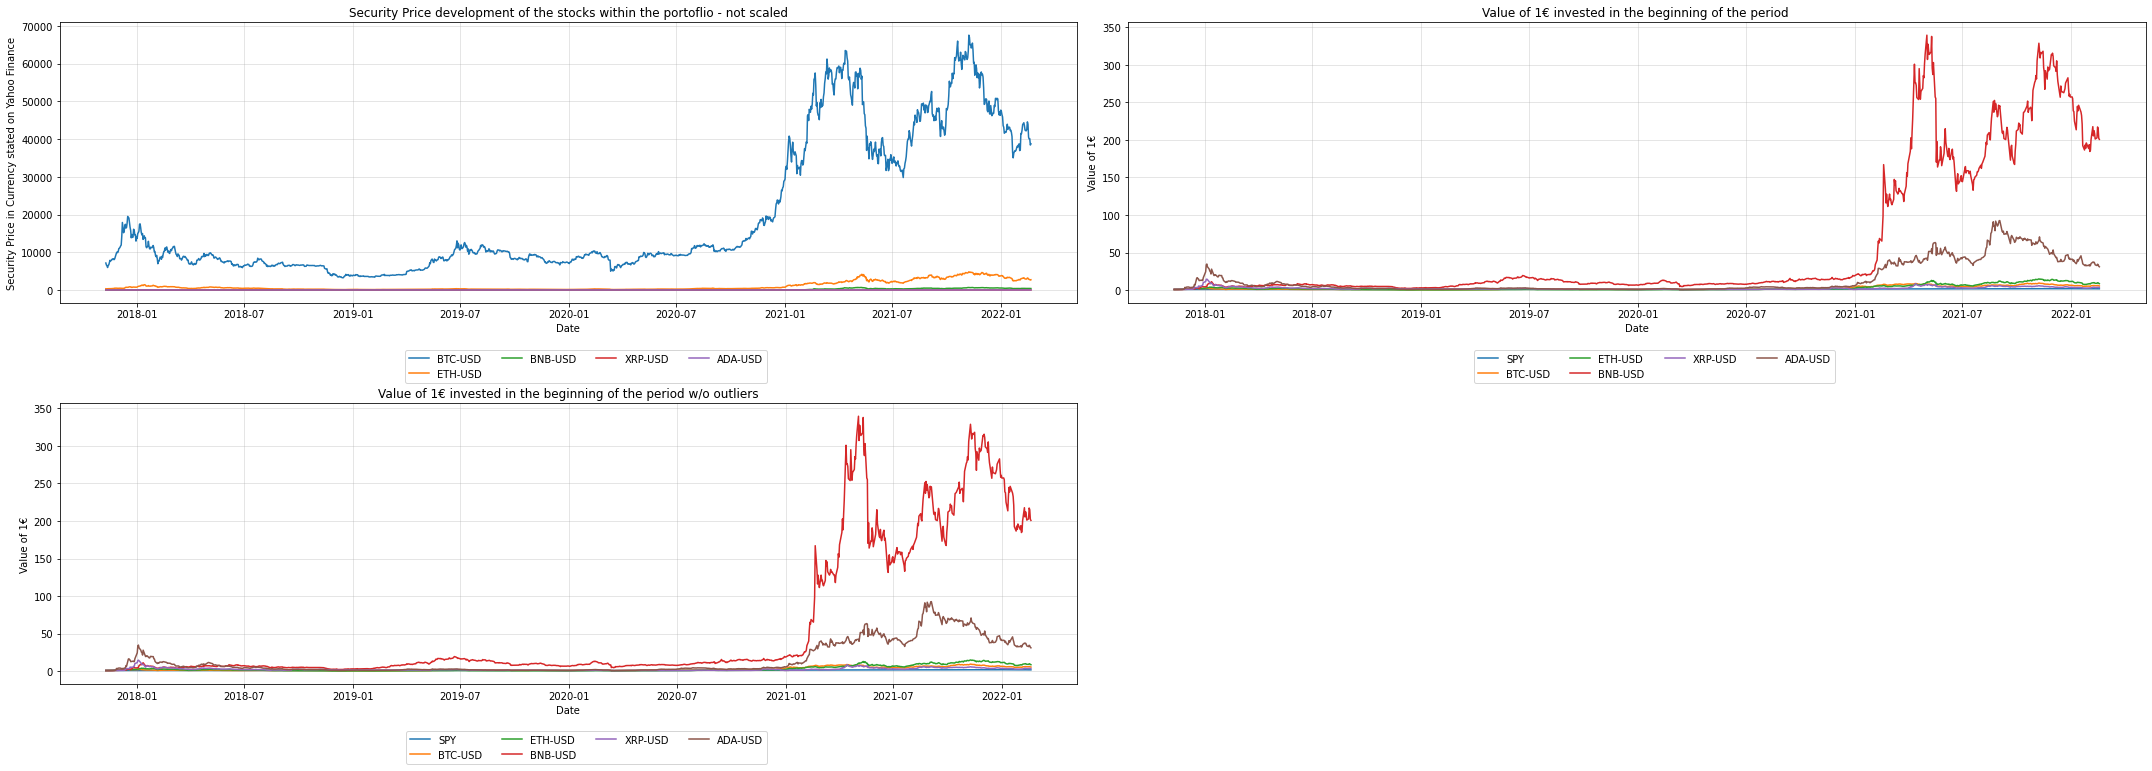

In [31]:
columns = data.columns
fig, ax = plt.subplots(figsize=(30,15))
plt.subplot(3,2,1)
for col in columns:
    plt.plot(data[col]) #Data plotted w/o the benchmark as it has to be scaled at times 
    plt.xlabel('Date')
    plt.ylabel('Security Price in Currency stated on Yahoo Finance')
    plt.title('Security Price development of the stocks within the portoflio - not scaled')
    plt.grid(alpha = 0.4)
    plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

columns = plot_data.columns
plt.subplot(3,2,2)
plt.plot((plot_data.pct_change() + 1).cumprod()) # value of 1€ invested in the beginning of the period 
plt.xlabel('Date')
plt.ylabel('Value of 1€')
plt.title('Value of 1€ invested in the beginning of the period ')
plt.grid(alpha = 0.4)
plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

#Removing outlier to see the returns better (if there are any)
plt.subplot(3,2,3)
plt.plot(((plot_data.loc[:, plot_data.columns!='KP5.F']).pct_change()+1).cumprod()) # value of 1€ invested in the beginning of the period 
plt.xlabel('Date')
plt.ylabel('Value of 1€')
plt.title('Value of 1€ invested in the beginning of the period w/o outliers')
plt.grid(alpha = 0.4)
plt.legend(columns, ncol=4, fancybox=True, bbox_to_anchor=(0.70, -0.15))

plt.tight_layout()



In [19]:
#creating the minimum volatility weight function to be used in the minvol algo
def calc_pypf_minvol_weights(prices):
    mu = mean_historical_return(prices, compounding= True)
    s  = risk_matrix(prices, method= "sample_cov")
    
    ef =  EfficientFrontier(mu, s)
    minvol_weights = ef.min_volatility()

    return minvol_weights

#create the weighminvol class to be used as an algo in the bt framework
class WeighMinVol(Algo):

    """
    Sets temp['weights'] based on minimum variance optimization.

    Sets the target weights based on calc_min_vol_weights.

    Args:
        * lookback (DateOffset): lookback period for estimating volatility
        * bounds ((min, max)): tuple specifying the min and max weights for
          each asset in the optimization.
        * covar_method (str): method used to estimate the covariance.
        * rf (float): risk-free rate used in optimization.

    Sets:
        * weights

    Requires:
        * selected
    """

    def __init__(
        self,
        lookback=pd.DateOffset(months=3),
        bounds=(0.0, 1.0),
        covar_method="ledoit-wolf",
        rf=0.0,
        lag=pd.DateOffset(days=0),
    ):
        super(WeighMinVol, self).__init__()
        self.lookback = lookback
        self.lag = lag
        self.bounds = bounds
        self.covar_method = covar_method
        self.rf = rf

    def __call__(self, target):
        selected = target.temp["selected"]

        if len(selected) == 0:
            target.temp["weights"] = {}
            return True

        if len(selected) == 1:
            target.temp["weights"] = {selected[0]: 1.0}
            return True

        t0 = target.now - self.lag
        prc = target.universe.loc[t0 - self.lookback : t0, selected]
        tw = calc_pypf_minvol_weights(prc)

        target.temp["weights"] = tw
        return True

In [20]:
strategy_meanvar = bt.Strategy('Strategy Maximum Sharpe Ratio', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighMeanVar(covar_method='standard'),
                    bt.algos.Rebalance()])

strategy_minvol = bt.Strategy('Strategy Minimum Volatility', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    WeighMinVol(covar_method='standard'),
                    bt.algos.Rebalance()])

strategy_1n =  bt.Strategy('Strategy 1/N', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighEqually(),
                    bt.algos.Rebalance()])

strategy_invvol =  bt.Strategy('Strategy Inverse Volatility', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighInvVol(),
                    bt.algos.Rebalance()])

strategy_erc =  bt.Strategy('Equal Risk Contribution', [
                    bt.algos.RunMonthly(run_on_first_date=True, run_on_end_of_period=False),
                    #bt.algos.RunAfterDate('2020-10-22'),
                    bt.algos.SelectHasData(),
                    bt.algos.WeighERC(covar_method='standard', risk_parity_method='ccd', maximum_iterations = 10000),
                    bt.algos.Rebalance()])



In [21]:
#Markowitz portfolio
backtest_meanvar = bt.Backtest(strategy_meanvar, data)
result_meanvar   = bt.run(backtest_meanvar)

#Minimum Volatility
backtest_minvol = bt.Backtest(strategy_minvol, data)
result_minvol   = bt.run(backtest_minvol)

#1/N portfolio
backtest_1n = bt.Backtest(strategy_1n, data)
result_1n   = bt.run(backtest_1n)

#Inverse Volatility 
backtest_invvol = bt.Backtest(strategy_invvol, data)
result_invvol = bt.run(backtest_invvol)

#Equal Risk Contribution 
backtest_erc = bt.Backtest(strategy_erc, data)
result_erc = bt.run(backtest_erc)


In [22]:
bt.run(backtest_meanvar, backtest_minvol, backtest_invvol, backtest_erc, backtest_1n).plot()

plt.figure(figsize=(15,5))
plt.plot((data_benchmark.pct_change()+1).cumprod()*100, label = 'Benchmark Peformance')
plt.legend()

In [23]:
weights_meanvar = result_meanvar.get_security_weights()
weights_minvol = result_minvol.get_security_weights()
weights_1n = result_1n.get_security_weights()
weights_invvol = result_invvol.get_security_weights()
weights_erc = result_erc.get_security_weights()

#plotting the weights
fig, ax = plt.subplots(figsize=(30,15))

plt.subplot(3,2,1)
plt.plot(weights_minvol)
plt.title('MinVol Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_minvol.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.subplot(3,2,2)
plt.plot(weights_meanvar)
plt.title('MeanVar Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_meanvar.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.subplot(3,2,3)
plt.plot(weights_1n)
plt.title('1/N Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_1n.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.subplot(3,2,4)
plt.plot(weights_invvol)
plt.title('Inverse Volatility Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_invvol.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.subplot(3,2,5)
plt.plot(weights_erc)
plt.title('Equal Risk Contribution Weights Monthly Rebalancing Baseline Portfolio')
plt.legend(labels = weights_erc.columns, ncol=4, fancybox=True, bbox_to_anchor=(0.75, -0.1))
plt.grid(alpha = 0.6)

plt.tight_layout()

In [24]:
def max_dd(total_r_series, days=250, minmin = True):
    """
    Maximum Draw-down during the last 12M
    """
    if minmin == True:
        roll_max = total_r_series.rolling(min_periods=1,window=days).max()

        daily_drawdown = total_r_series / roll_max - 1

        max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=days).min().min()

        return max_daily_drawdown
        
    else:
        roll_max = total_r_series.rolling(min_periods=1,window=days).max()

        daily_drawdown = total_r_series / roll_max - 1

        max_daily_drawdown = daily_drawdown.rolling(min_periods=1,window=days).min()

        return max_daily_drawdown

total_return_benchmark = (data_benchmark.pct_change()+1).cumprod().iloc[-1] - 1
std_benchmark = (data_benchmark.pct_change()).std() * np.sqrt((252))
mu_benchmark = mean_historical_return(data_benchmark, compounding= True)
sr_benchmark = mu_benchmark / std_benchmark
skew_benchmark = (data_benchmark.pct_change()).skew()
max_dd_benchmark = max_dd((data_benchmark.pct_change()+1).cumprod())
kurt_benchmark = (data_benchmark.pct_change()).kurt()

print("\nBenchmark's Total Return Factor: ", round(total_return_benchmark[-1],2), "\nBenchmark's Standard Deviation: ", round(std_benchmark[-1],4),
      "\nBenchmark's mean historical return: ", round(mu_benchmark[-1],4), "\nBenchmark's Sharpe Ratio", round(sr_benchmark[-1],2), 
      "\nBenchmark's return skewness", round(skew_benchmark[-1],4), "\nBencmark's maximum drawdown", round(max_dd_benchmark[-1],2), 
      "\nBenchmark's return kurtosis", round(kurt_benchmark[-1],4))


Benchmark's Total Return Factor:  1.01 
Benchmark's Standard Deviation:  0.1912 
Benchmark's mean historical return:  0.1499 
Benchmark's Sharpe Ratio 0.78 
Benchmark's return skewness -0.7486 
Bencmark's maximum drawdown -0.34 
Benchmark's return kurtosis 17.1695


In [25]:
results = pd.DataFrame()
results = pd.DataFrame(index = result_meanvar.stats.index)
results["Strategy MSR"] = result_meanvar.stats
results["Strategy MinVol"] = result_minvol.stats
results["Strategy InvVol"] = result_invvol.stats
results["Equal Risk Contribution"] = result_erc.stats
results["Strategy 1/N"] = result_1n.stats
results

,Strategy MSR,Strategy MinVol,Strategy InvVol,Equal Risk Contribution,Strategy 1/N
start,2017-11-08 00:00:00,2017-11-08 00:00:00,2017-11-08 00:00:00,2017-11-08 00:00:00,2017-11-08 00:00:00
end,2022-02-21 00:00:00,2022-02-21 00:00:00,2022-02-21 00:00:00,2022-02-21 00:00:00,2022-02-21 00:00:00
rf,0.0,0.0,0.0,0.0,0.0
total_return,8.252791,9.404709,10.498135,10.53135,8.273218
cagr,0.680239,0.726856,0.767576,0.768766,0.681104
max_drawdown,-0.743057,-0.744566,-0.778862,-0.775049,-0.790078
calmar,0.915461,0.976215,0.98551,0.991893,0.862071
mtd,0.007862,0.011972,0.042832,0.040557,0.036332
three_month,-0.378814,-0.351904,-0.347418,-0.34917,-0.355986
six_month,-0.328554,-0.229615,-0.275272,-0.279083,-0.300156


In [26]:
result_invvol.get_transactions().tail(10)

price  quantity
Date       Security                        
2021-12-01 XRP-USD       0.990930  586278.0
2022-01-01 ADA-USD       1.376975 -472019.0
           BNB-USD     527.352722     452.0
           ETH-USD    3769.697021      78.0
           XRP-USD       0.849472  124224.0
2022-02-01 ADA-USD       1.088624 -290232.0
           BNB-USD     385.463806     132.0
           BTC-USD   38743.273438       3.0
           ETH-USD    2792.117188      -9.0
           XRP-USD       0.629233  272704.0

In [27]:
result_meanvar.get_security_weights().tail()

,ETH-USD,BNB-USD,XRP-USD,ADA-USD,BTC-USD
2022-02-17,0.0,0.999979,0.0,0.0,0.0
2022-02-18,0.0,0.999979,0.0,0.0,0.0
2022-02-19,0.0,0.999979,0.0,0.0,0.0
2022-02-20,0.0,0.999978,0.0,0.0,0.0
2022-02-21,0.0,0.999978,0.0,0.0,0.0
